In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pandas as pd
import os,sys
import glob
import scipy
from scipy import interpolate

from astropy.cosmology import Planck15 as P15
from astropy import units as u
from astropy import constants as const

import run_LF as LF

plt.style.use(['default','seaborn-colorblind','seaborn-ticks'])
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'

# Test adding uncertainty to LF model

- If model UV LF has 0.2dex uncertainty at every Muv value, what is uncertainty in Lya LF model?
- How does Lya LF model uncertainty change neutral fraction inference?

$$ \phi(L_\alpha) = F \int dM_\mathrm{UV} \phi(M_\mathrm{UV}) p(L_\alpha | M_\mathrm{UV}) $$

In [2]:
model_dir = os.environ['LYA_DATA_DIR']+'data/models/'
UVLF_dir  = model_dir+'MTT15_UVLF/LF_pred/'

LF_tab = LF.load_uvf_pandas(UVLF_dir+'LF_pred_z6.8.txt')
LF_tab = LF_tab[LF_tab.Muv < -11]

## Lyman alpha luminosity PDF

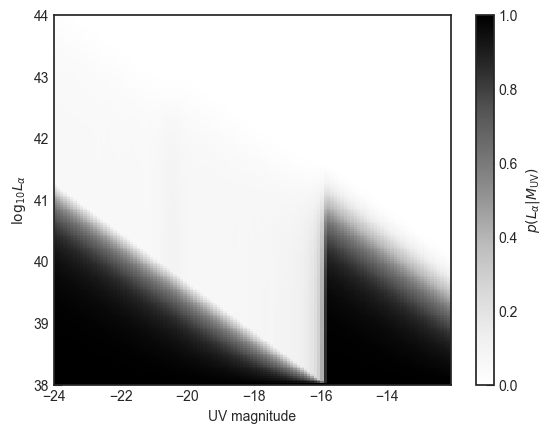

In [3]:
Muv_grid, pL_Lya = LF.make_pL_Lya(zval_test=6.8, xHI_test=0.01)

plt.pcolor(Muv_grid, LF.log10_lg, pL_Lya/np.max(pL_Lya, axis=0))

plt.xlabel('UV magnitude')
plt.ylabel(r'$\log_{10} L_\alpha$')

plt.colorbar(label=r'$p(L_\alpha | M_\mathrm{UV})$')

## Make LF with 0.2 dex uncertainty

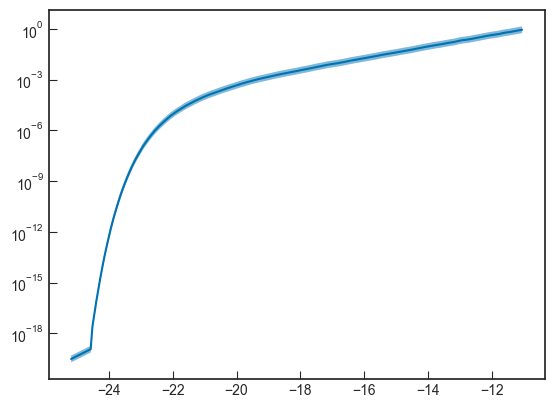

In [4]:
log_ndens_sigma = 0.2
ndens_l = 10**(np.log10(LF_tab['ndens']) - log_ndens_sigma)
ndens_u = 10**(np.log10(LF_tab['ndens']) + log_ndens_sigma)

plt.semilogy(LF_tab['Muv'], LF_tab['ndens'])
plt.fill_between(LF_tab['Muv'], ndens_l, ndens_u, alpha=0.5)

## Sample from LF

- Sample 1000 UV LFs
- Calculate Lya LF based on each UV LF
- Calculate the standard deviation of the Lya LFs

True sigma:0.2, Recovered sigma:0.1974


Text(0, 0.5, '$\\phi(M_\\mathrm{UV})$ [Mpc$^{-3}$]')

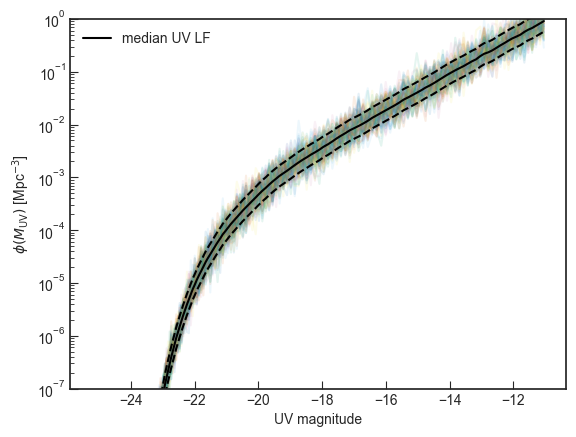

In [5]:
# create 100 different UV LFs
N_sample = 100
sample_UV_LF = np.array([np.random.normal(loc=np.log10(LF_tab['ndens']), scale=log_ndens_sigma) for i in range(N_sample)])
log_ndens_sigma_samples = np.median(np.std(sample_UV_LF, axis=0))
print(f'True sigma:{log_ndens_sigma}, Recovered sigma:{log_ndens_sigma_samples:.4f}')

# Plot each of the sample LFs
plt.plot(LF_tab['Muv'], 10**sample_UV_LF.T, alpha=0.1)

# Compare with median LF + upper + lower error bars
ln = plt.semilogy(LF_tab['Muv'], LF_tab['ndens'], c='k', label='median UV LF')
plt.plot(LF_tab['Muv'], ndens_l, c=ln[0].get_color(), ls='dashed')
plt.plot(LF_tab['Muv'], ndens_u, c=ln[0].get_color(), ls='dashed')

plt.legend()
plt.ylim(1e-7, 1e0)

plt.xlabel('UV magnitude')
plt.ylabel('$\phi(M_\mathrm{UV})$ [Mpc$^{-3}$]')

## Make Lya LFs with the UV LF samples

In [6]:
def make_lya_LF(ndens, new_pLya, F=1., plot=False, log=True):
    """
    Cut out of original function
        - interpolate given UV ndens on Muv_grid
        - multiply by p(L | Muv)
        - integrate to get Lya LF
    """
    
    #Interpolating UV LF Muv and ndens values into a 1d array
    LF_interp = interpolate.interp1d(LF_tab['Muv'], ndens)
    new_ndens = LF_interp(Muv_grid)

    #Product of UVLF ndens values * pLya in new luminosity grid
    product_LF = new_ndens * new_pLya

    #Integral of this product = Lya LF (missing fudge factor corrections)
    lya_LF = np.trapz(product_LF, Muv_grid) 

    #Log10 of Lya LF is lya_LF value * Jacobian - partial L / partial log10(L)
    log10_LF = lya_LF*np.log(10)*LF.lum_grid
        
    return log10_LF

Text(0, 0.5, '$\\phi(\\log_{10} L_\\alpha)$ [Mpc$^{-3}$]')

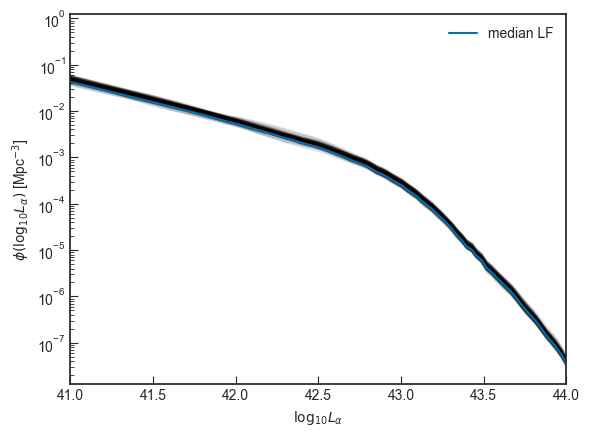

In [7]:
# make a Lya LF with each UV LF
log10_LF_samples = np.array([make_lya_LF(10**sample_UV_LF[i], new_pLya=pL_Lya) for i in range(N_sample)])
plt.semilogy(LF.log10_lg, log10_LF_samples.T, alpha=0.1, c='k')

# Calculate standard deviation of the Lya LF
std_Lya = np.std(log10_LF_samples, axis=0)

# Make the 'normal' Lya LF from the median UV LF
log10_LF = make_lya_LF(LF_tab['ndens'], new_pLya=pL_Lya)
plt.semilogy(LF.log10_lg, log10_LF, label='median LF')

plt.legend()
plt.xlim(41, 44)
# plt.ylim(-6, -1)

plt.xlabel(r'$\log_{10} L_\alpha$')
plt.ylabel(r'$\phi(\log_{10} L_\alpha)$ [Mpc$^{-3}$]')

## Recovered Lya LF uncertainty ~ 10%

Text(0.5, 0, '$\\log_{10} L_\\alpha$')

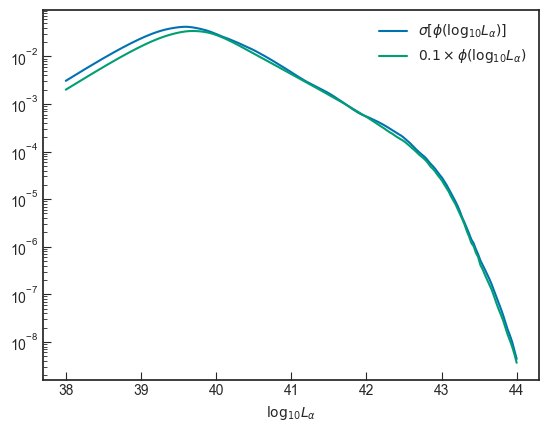

In [8]:
plt.semilogy(LF.log10_lg, std_Lya, label=r'$\sigma[\phi(\log_{10} L_\alpha)]$')
plt.semilogy(LF.log10_lg, log10_LF/10, label=r'$0.1 \times \phi(\log_{10} L_\alpha)$')

plt.legend()
plt.xlabel(r'$\log_{10} L_\alpha$')

# Try to calculate $p(\phi)$ directly

(doesn't go well :( )

Text(0, 0.5, '$\\log_{10} \\phi(M_\\mathrm{UV})$')

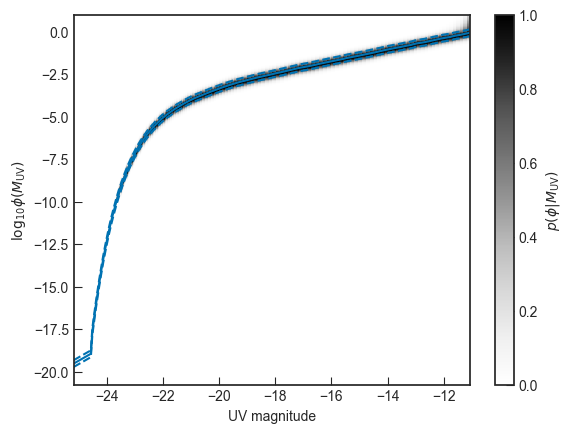

In [9]:
def make_p_ndens(ndens_grid, ndens, sigma=0.2):
    p = np.exp(-0.5*((np.log10(ndens_grid) - np.log10(ndens))**2.)/sigma**2.)/ndens_grid/np.log(10.)/np.sqrt(2*np.pi)/sigma
    return p

ndens_grid = np.logspace(-10,1, 500)

p_ndens = make_p_ndens(ndens_grid, LF_tab['ndens'][:,None], sigma=0.2)
plt.pcolor(LF_tab['Muv'], np.log10(ndens_grid), (p_ndens/np.max(p_ndens, axis=0)).T)

plt.colorbar(label=r'$p(\phi | M_\mathrm{UV})$')

ln = plt.plot(LF_tab['Muv'], np.log10(LF_tab['ndens']), label='Mean + upper + lower uncertainties')
plt.plot(LF_tab['Muv'], np.log10(ndens_l), c=ln[0].get_color(), ls='dashed')
plt.plot(LF_tab['Muv'], np.log10(ndens_u), c=ln[0].get_color(), ls='dashed')

plt.xlabel('UV magnitude')
plt.ylabel(r'$\log_{10} \phi(M_\mathrm{UV})$')

# plt.xlim(-23.5,-14)
# plt.ylim(-7, -1)

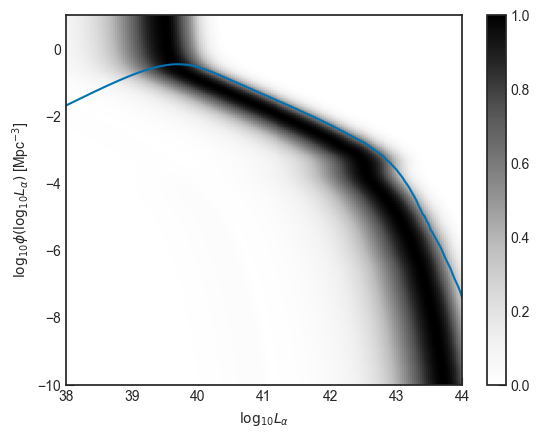

In [10]:
def make_lya_LF_2D(p_ndens, new_pLya, F=1., plot=False, log=True):
    """
    """
    
    #Interpolating UV LF Muv and ndens values into a 2d array
    LF_interp = interpolate.interp2d(LF_tab['Muv'], ndens_grid, p_ndens.T) #old values
    new_ndens = LF_interp(Muv_grid, ndens_grid)

    #Product of UVLF ndens values * pLya in new luminosity grid
    product_LF = new_ndens * new_pLya[:,None]

    #Integral of this product = Lya LF (missing fudge factor corrections)
    lya_LF =np.trapz(product_LF, x = Muv_grid) 

    #Log10 of Lya LF is lya_LF value * Jacobian - partial L / partial log10(L)
    log10_LF = lya_LF*np.log(10)*LF.lum_grid[:,None]
    
    plt.pcolor(LF.log10_lg, np.log10(ndens_grid), (log10_LF/np.max(log10_LF, axis=0)).T)
    plt.colorbar()
    
    plt.xlabel(r'$\log_{10} L_\alpha$')
    plt.ylabel(r'$\log_{10} \phi(\log_{10} L_\alpha)$ [Mpc$^{-3}$]')
    
    return log10_LF

log10_LF = make_lya_LF_2D(p_ndens=p_ndens, new_pLya=pL_Lya)
log10_LF = make_lya_LF(LF_tab['ndens'], new_pLya=pL_Lya)
plt.plot(LF.log10_lg, np.log10(log10_LF), label='median LF')